# Modulation-Classification

Developing AutoML Model for RadioML Dataset for Modulation Classification. SNR Ratio's(in dB) of Channel are $[−20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18]$.

**Data**: RadioML Dataset

**Modulation Classification:**
We will use AutoML to create a Classifier to Predict Labels.

## Imports


### GPU Information

The following GPU is used while Training the Model. Google Colab is used for Training so the GPU might change while running it later.

**GPU-Specifications:**
*   Name: Tesla P100
*   GPU Memory: 16280MiB

In [1]:
!nvidia-smi

Wed Jul 28 06:29:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    50W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/RadioML-Dataset/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/RadioML-Dataset/AutoML


### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# AutoML Libraries
!pip3 install autokeras==1.0.12
!pip3 install tensorflow==2.4
!pip3 install keras-tuner==1.0.2
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, ReLU, Conv2D, Input, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape, ZeroPadding2D, Dropout
from tensorflow.keras.models import Model

## Customised AutoML Blocks

In [4]:
class ReshapeLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        dims = input_node.shape.as_list()[1:]
        output_node = tf.keras.layers.Reshape((dims[0],dims[1]*dims[2]))(input_node)
        return output_node

class AddDimsLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        output_node = tf.expand_dims(input_node,axis=1)
        return output_node

class PermuteLayerBlock(ak.Block):
    def build(self, hp, shape=None, inputs=None):
        input_node = inputs[0]
        dims = len(input_node.shape.as_list()[1:])
        output_node = tf.keras.layers.Permute([*range(dims,0,-1)])(input_node)
        return output_node

Callbacks

In [5]:
EarlyStoppingCallbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

## AutoML CNN Model Training for Clean Data

### Importing Data

In [6]:
# Loading Training Data
Clean_X_Train = np.load("../Data/Clean-Data/Clean_X_Train.npy")
Clean_y_Train = np.load("../Data/Clean-Data/Clean_y_Train.npy")
Clean_X_Train, Clean_X_Valid, Clean_y_Train, Clean_y_Valid = train_test_split(Clean_X_Train, Clean_y_Train, test_size=0.05, stratify=Clean_y_Train)

### AutoML Model

Creating Classifier

In [7]:
tf.keras.backend.clear_session()

input_node = ak.Input()
addDims_node = AddDimsLayerBlock()(input_node)
permute_node = PermuteLayerBlock()(addDims_node)
conv_node = ak.ConvBlock()(permute_node)
dense_node = ak.DenseBlock()(conv_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=20,
                                project_name="CNN_Model/0")

RadioMLClassifier.fit(Clean_X_Train, Clean_y_Train, epochs=10, batch_size=3072, validation_data=(Clean_X_Valid,Clean_y_Valid), shuffle=True,callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Trial 20 Complete [00h 00m 53s]
val_loss: 1.6434656381607056

Best val_loss So Far: 1.5418988466262817
Total elapsed time: 00h 10m 44s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./CNN_Model/0/best_model/assets


Exporting Model and Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 2, 128)            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1, 2, 128)         0         
_________________________________________________________________
permute (Permute)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1, 32)         0     

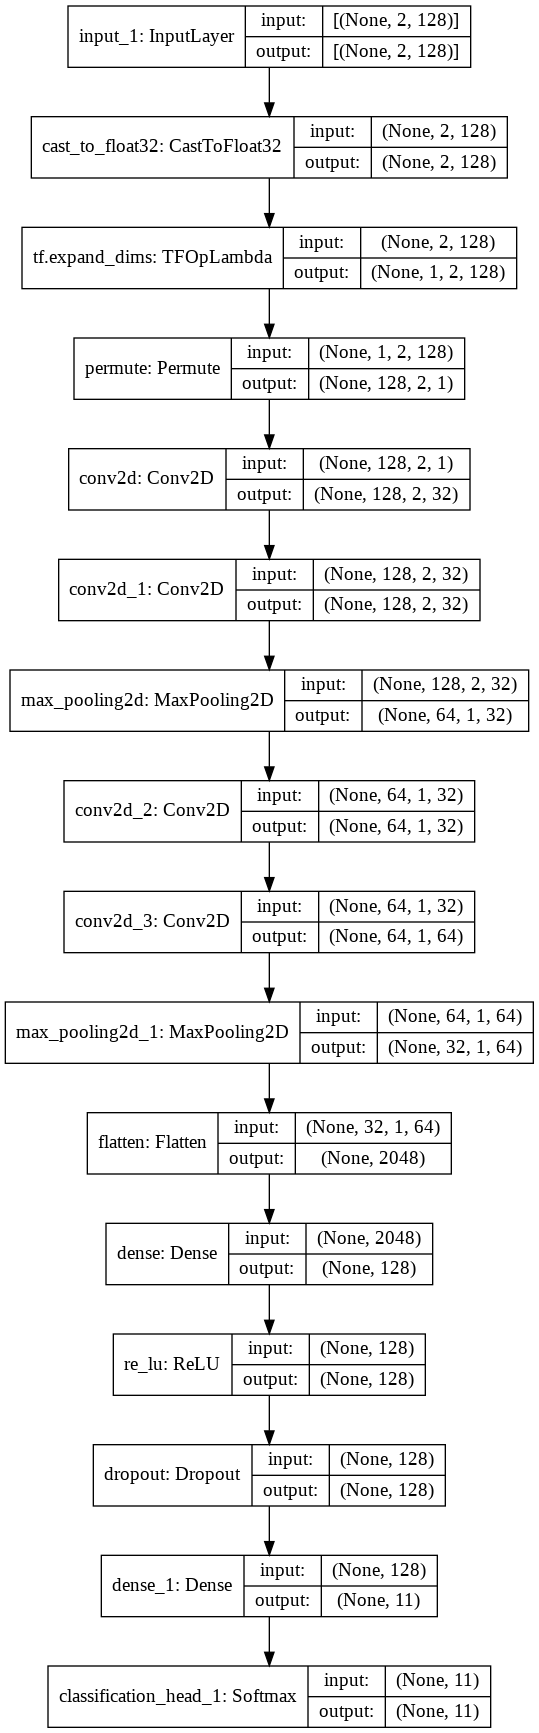

In [16]:
RadioML_Model = RadioMLClassifier.export_model()
RadioML_Model.summary()
tf.keras.backend.clear_session()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/Clean_CNN.png', show_shapes=True,show_layer_names=True)

Training Model

In [17]:
RadioML_Model.fit(Clean_X_Train, Clean_y_Train, epochs=100, batch_size=3072, validation_data=(Clean_X_Valid,Clean_y_Valid), shuffle=True)

Epoch 1/100
55/55 [==============================] - 3s 38ms/step - loss: 1.6182 - accuracy: 0.3993 - val_loss: 1.5314 - val_accuracy: 0.4283
Epoch 2/100
55/55 [==============================] - 2s 34ms/step - loss: 1.5442 - accuracy: 0.4228 - val_loss: 1.5198 - val_accuracy: 0.4270
Epoch 3/100
55/55 [==============================] - 2s 34ms/step - loss: 1.5340 - accuracy: 0.4257 - val_loss: 1.5090 - val_accuracy: 0.4338
Epoch 4/100
55/55 [==============================] - 2s 34ms/step - loss: 1.5251 - accuracy: 0.4293 - val_loss: 1.5057 - val_accuracy: 0.4370
Epoch 5/100
55/55 [==============================] - 2s 34ms/step - loss: 1.5143 - accuracy: 0.4332 - val_loss: 1.4923 - val_accuracy: 0.4326
Epoch 6/100
55/55 [==============================] - 2s 34ms/step - loss: 1.5088 - accuracy: 0.4353 - val_loss: 1.4833 - val_accuracy: 0.4424
Epoch 7/100
55/55 [==============================] - 2s 34ms/step - loss: 1.4968 - accuracy: 0.4388 - val_loss: 1.4733 - val_accuracy: 0.4474
Epoch 

Saving Model

In [19]:
RadioML_Model.save("../Models/Clean_CNN.h5")